In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
import numpy as np
import random
from scipy.optimize import curve_fit

import time
import os

Creazione del grafo con l'algoritmo di Barabasi-Albert

In [2]:
N = 50
M = 3
G = nx.barabasi_albert_graph(N, M)

Rappresentazione del grafico

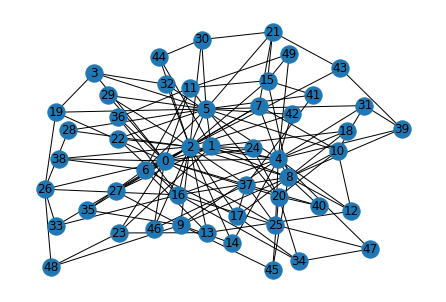

In [3]:
nx.draw(G, with_labels=True)    
plt.show()

nx.write_adjlist(G, "BA.adjlist")

Distribuzione della connettività dei nodi

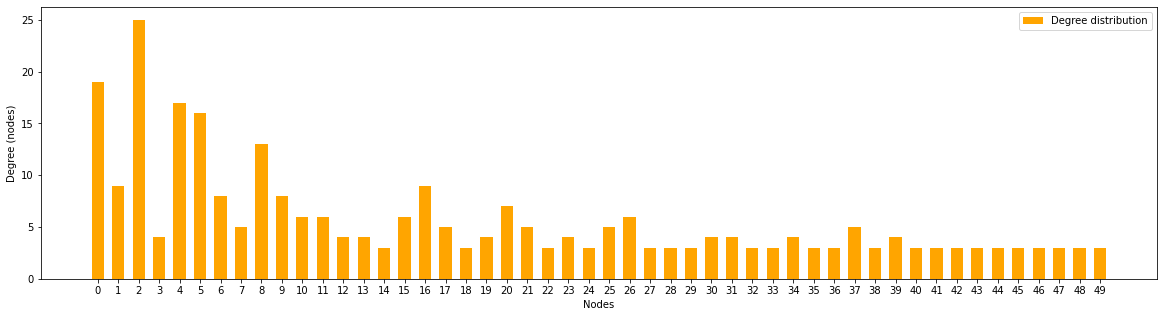

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.4*N, 5))

ax.bar(G.nodes, [d for n,d in G.degree], width=0.6, 
          align='center', color='orange', label='Degree distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Degree (nodes)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

Estrazione della matrice di adiacenza A

In [5]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

Estrazione della matrice di stocastica P e calcolo dei suoi autovalori e autovettori

In [6]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [31]:
matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)
for i in range(N):
    if np.round(autovaloriP[i], 5) == 1:
        pS = autovettoriP[i]
        print("Eigenvector found")
        break
if pS[0] < 0:
    pS = -pS

Eigenvector found


In [8]:
autovaloriP

array([ 1.00000000e+00+0.00000000e+00j,  6.22594511e-01+0.00000000e+00j,
        6.01476777e-01+0.00000000e+00j,  5.74790913e-01+0.00000000e+00j,
        5.37822212e-01+0.00000000e+00j, -6.34875702e-01+0.00000000e+00j,
       -6.07918383e-01+0.00000000e+00j, -5.96017112e-01+0.00000000e+00j,
       -5.91028786e-01+0.00000000e+00j,  4.91187869e-01+0.00000000e+00j,
        4.73568003e-01+0.00000000e+00j,  4.35149952e-01+0.00000000e+00j,
        4.10259056e-01+0.00000000e+00j,  4.13843423e-01+0.00000000e+00j,
        3.84365665e-01+0.00000000e+00j, -5.27822042e-01+0.00000000e+00j,
       -5.06108449e-01+0.00000000e+00j, -5.04207208e-01+0.00000000e+00j,
        3.33080912e-01+0.00000000e+00j,  3.14171183e-01+0.00000000e+00j,
       -4.46403213e-01+0.00000000e+00j,  2.67950606e-01+0.00000000e+00j,
        2.58984375e-01+0.00000000e+00j, -4.18519780e-01+0.00000000e+00j,
       -3.93718849e-01+0.00000000e+00j, -3.89885930e-01+0.00000000e+00j,
       -3.62898187e-01+0.00000000e+00j, -3.21254426

Definizione della matrice laplaciana L e calcolo dei suoi autovettori e autovalori

In [9]:
matrixL = np.identity(N) - matrixP

In [10]:
autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)
pS_L = autovettoriL[0]
if pS_L[0] < 0:
    pS_L = -pS_L

In [11]:
autovaloriL

array([-3.37973711e-17,  3.77405489e-01,  3.98523223e-01,  4.25209087e-01,
        4.62177788e-01,  1.63487570e+00,  1.60791838e+00,  1.59601711e+00,
        1.59102879e+00,  5.08812131e-01,  5.26431997e-01,  1.52782204e+00,
        1.50610845e+00,  1.50420721e+00,  5.64850048e-01,  5.89740944e-01,
        5.86156577e-01,  6.15634335e-01,  6.66919088e-01,  6.85828817e-01,
        1.44640321e+00,  7.32049394e-01,  7.41015625e-01,  1.41851978e+00,
        1.39371885e+00,  1.38988593e+00,  1.36289819e+00,  8.05381309e-01,
        8.33042272e-01,  8.53571398e-01,  8.77019393e-01,  8.98182521e-01,
        9.19310577e-01,  9.49130815e-01,  9.66368926e-01,  1.32125443e+00,
        1.30945403e+00,  1.27342349e+00,  1.24854630e+00,  1.21207363e+00,
        1.17039393e+00,  1.15146473e+00,  1.13654100e+00,  1.08972783e+00,
        1.06419220e+00,  1.06076304e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00])

La distribuzione stazionaria e il valore di Fiedler estratto dalle due matrici L e P coincidono fino alla 13-esima cifra decimale

In [12]:
i = 13
np.round(pS, i) == np.round(pS_L, i)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [13]:
np.round(1-max(autovaloriP[1:]), i) == np.round(min(autovaloriL[1:]), i)

True

Definizione del valore valore di Fiedler e della distribuzione stazionaria approssimate

In [14]:
FiedlerValue = round(min(autovaloriL[1:]), i)
print(FiedlerValue)

0.3774054892613


In [15]:
pS = np.round(pS.real, i)
print(pS)

[0.36908863 0.17483146 0.48564293 0.07770287 0.33023719 0.31081148
 0.15540574 0.09712859 0.25253432 0.15540574 0.1165543  0.1165543
 0.07770287 0.07770287 0.05827715 0.1165543  0.17483146 0.09712859
 0.05827715 0.07770287 0.13598002 0.09712859 0.05827715 0.07770287
 0.05827715 0.09712859 0.1165543  0.05827715 0.05827715 0.05827715
 0.07770287 0.07770287 0.05827715 0.05827715 0.07770287 0.05827715
 0.05827715 0.09712859 0.05827715 0.07770287 0.05827715 0.05827715
 0.05827715 0.05827715 0.05827715 0.05827715 0.05827715 0.05827715
 0.05827715 0.05827715]


In [16]:
with open("BA-pS.txt", "w") as file:
    file.write("\n".join([str(i) for i in pS]))

Assegnazione degli individui ai nodi per l'evoluzione della dinamica. L'assegnazione degli individui è fatta secondo una distribuzione uniforme.

In [17]:
walker_per_node = 200

In [18]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[new_node] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[n]
    history += [evolution]

In [19]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

In [20]:
time_steps = int(5e1)

In [21]:
t0 = time.time()

for h in range(len(history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
#         t1 = time.time()
        dynamic_evolution(G, history[h])
#         print(f"done in {int((time.time()-t1)/60)} minutes and {((time.time()-t1)%60)} seconds")

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 27.658560037612915 seconds


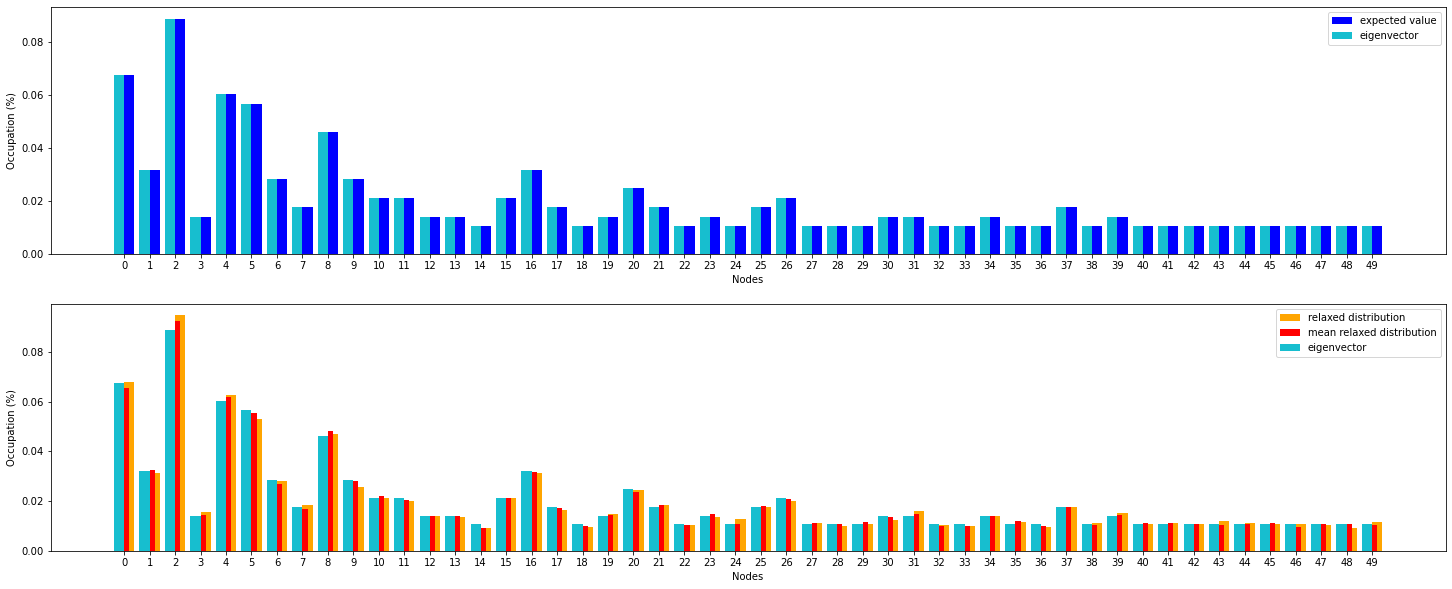

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSExpected = [d for n, d in G.degree()]
pSNorm = [h/sum(pS) for h in pS]

hMean = [[(h1+h2+h3)/walker_per_node/N/3 
          for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

ax[0].bar(G.nodes, [h/sum(pSExpected) for h in pSExpected], width=0.4, align='edge', color='blue', label="expected value")
ax[0].bar(G.nodes, [h for h in pSNorm], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

ax[1].bar(G.nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax[1].bar(G.nodes, hMean[-1], width=0.2, align='edge', color='red', label='mean relaxed distribution')
ax[1].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)


plt.show()

In [23]:
print(pSNorm)

[0.0673758865248369, 0.0319148936170232, 0.08865248226950688, 0.014184397163125482, 0.06028368794327417, 0.05673758865248366, 0.028368794326250963, 0.017730496453897723, 0.04609929078014869, 0.028368794326250963, 0.02127659574468822, 0.02127659574468822, 0.014184397163125482, 0.014184397163125482, 0.010638297872334983, 0.02127659574468822, 0.0319148936170232, 0.017730496453897723, 0.010638297872334983, 0.014184397163125482, 0.024822695035460467, 0.017730496453897723, 0.010638297872334983, 0.014184397163125482, 0.010638297872334983, 0.017730496453897723, 0.02127659574468822, 0.010638297872334983, 0.010638297872334983, 0.010638297872334983, 0.014184397163125482, 0.014184397163125482, 0.010638297872334983, 0.010638297872334983, 0.014184397163125482, 0.010638297872334983, 0.010638297872334983, 0.017730496453897723, 0.010638297872334983, 0.014184397163125482, 0.010638297872334983, 0.010638297872334983, 0.010638297872334983, 0.010638297872334983, 0.010638297872334983, 0.010638297872334983, 0

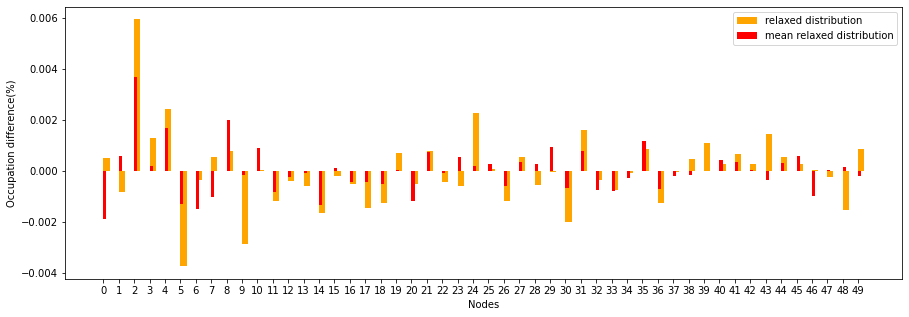

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(G.nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm)], width=0.4, 
       align='edge', color='orange', label='relaxed distribution')
ax.bar(G.nodes, [(h1+h2+h3)/(sum(history[0][-1]) + sum(history[1][-1]) + sum(history[2][-1])) - k 
                 for h1, h2, h3, k in zip(history[0][-1], history[1][-1], history[2][-1], pSNorm)],
       width=0.2, align='edge', color='red', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Occupation difference(%)")
ax.set_xticks(np.arange(0, N, 1))
# ax.grid(True)

plt.show()

In [25]:
def gaus_law(x, a, mu=0, sigma=1):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

from scipy.stats import binom
from scipy.stats import poisson

def binomial_law(x, n, p):
    return binom.pmf(x, n, p)

def poisson_law(x, a, lamb, loc):
    return a*poisson.pmf(x - loc, lamb)

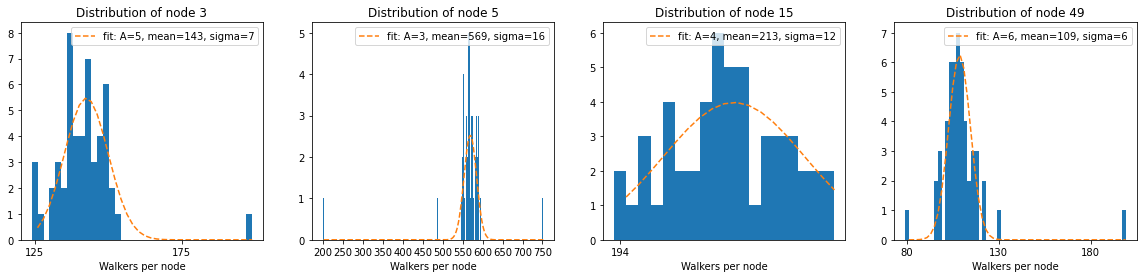

In [26]:
nodes = [3, 5, 15, N-1]
p_node = []

fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(5*len(nodes), 4))

histo = [[(h1+h2+h3)/3 for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

n = [0]*len(nodes)
bins = [0]*len(nodes)

for i in range(len(nodes)):
    p_node += [[int(h[nodes[i]]) for h in histo]]
    n[i], bins[i], patches = ax[i].hist(p_node[i],
                                        bins = int((max(p_node[i]) - min(p_node[i]))/2),
                                        align='left')
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_xlabel("Walkers per node")
    ax[i].set_xticks(np.arange(min(p_node[i]), max(p_node[i]), 50))
    
mean = [sum(p_node[i])/len(p_node[i]) for i in range(len(nodes))]

poptGaus = [0]*len(nodes)
pcovGaus = [0]*len(nodes)

bins = [(bins[i][:-1] + bins[i][1:])/2 for i in range(len(nodes))]

for i in range(len(nodes)):    
    poptGaus[i], pcovGaus[i] = curve_fit(gaus_law, bins[i], n[i], 
                                         p0 = [10, mean[i], 9])
    
    ax[i].plot(bins[i], gaus_law(bins[i], *poptGaus[i]), '--',
               label = f"fit: A={round(poptGaus[i][0])}, mean={round(poptGaus[i][1])}, sigma={round(poptGaus[i][2])}")
    ax[i].legend()

plt.show()

In [27]:
for i in range(len(nodes)):
    print("Distribution for node", nodes[i], ":")
    print(" - Data mean:", mean[i])
    print(" - Expected mean from eigenvector:", pSNorm[nodes[i]] * N * walker_per_node)
    print(" - Mean from gaussian fit:", poptGaus[i][1])
#     print(" - Mean from poisson fit:", poptPois[i][1])
    print()

Distribution for node 3 :
 - Data mean: 143.0392156862745
 - Expected mean from eigenvector: 141.84397163125482
 - Mean from gaussian fit: 142.59898935257561

Distribution for node 5 :
 - Data mean: 563.8235294117648
 - Expected mean from eigenvector: 567.3758865248367
 - Mean from gaussian fit: 568.9635628476457

Distribution for node 15 :
 - Data mean: 212.86274509803923
 - Expected mean from eigenvector: 212.76595744688217
 - Mean from gaussian fit: 213.1189756094952

Distribution for node 49 :
 - Data mean: 110.15686274509804
 - Expected mean from eigenvector: 106.38297872334984
 - Mean from gaussian fit: 108.68257308178806



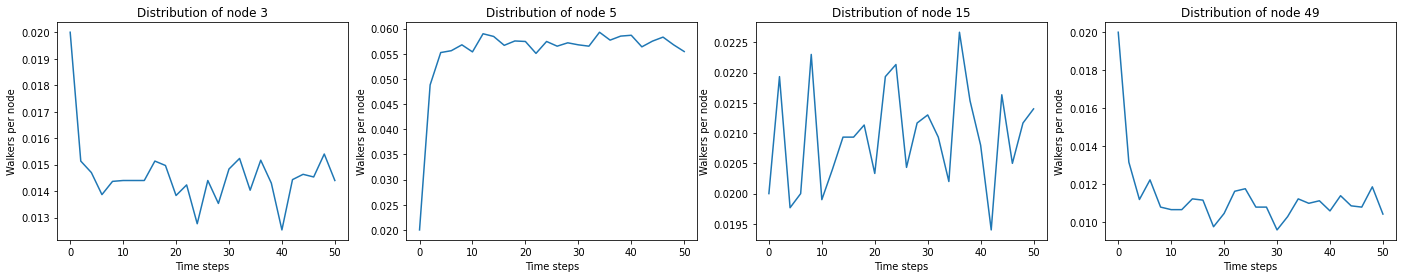

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(6*len(nodes), 4))

time_range = hMean
index = np.arange(0, len(time_range), 2)

for i in range(len(nodes)):
    ax[i].plot(index, [time_range[ind][nodes[i]] for ind in index])
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_ylabel("Walkers per node")
    ax[i].set_xlabel("Time steps")

plt.show()

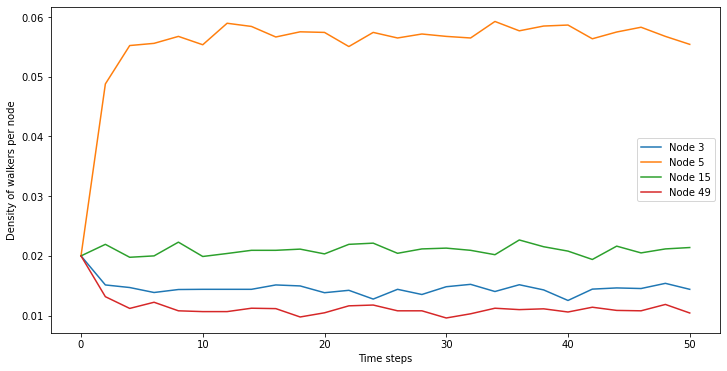

Evolution of 50 time steps starting from 200 walker per node


In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,1.5*len(nodes)))

for i in nodes: #list(G.nodes)[0:3]:
    plt.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}")
#     plt.plot(index, [time_range[ind][i] for ind in index])
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

print(f"Evolution of {time_steps} time steps starting from {walker_per_node} walker per node")

#### Note:

* aggiungere fit su distribuzioni di walkers

* sistema grafica concentrazioni di individui su ogni nodo

* fare grafico per fittare valore di Fiedler